# Image Compression Performance

Overall performance of my image display widget based on HTML `Canvas` element is very much dependent on choices made for compression and decompression.  It takes time to compress the image, transfer from back-end to front-end, then decompress and display.  I want to measure the round-trip times for this process with server and client both running on my laptop.

In [1]:
from __future__ import print_function, unicode_literals, division, absolute_import

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import addict
import imageio
import PIL
import IPython

from tictoc import Timer

from widget_canvas import widget_canvas

## Helper Function

In [2]:
import PIL
import io

def comp_imageio(data, fmt, **kwargs):
    """
    Helper function to compress data via imageio.
    """
    data_comp = imageio.imwrite(imageio.RETURN_BYTES, data, format=fmt, **kwargs)

    return data_comp


def restore_imageio(data_comp):
    """
    Decompress image from supplied byte data.
    """
    return imageio.imread(data_comp)


def comp_pillow(data, fmt, **kwargs):
    """
    Helper function to compress data via PIL/Pillow.
    
    Parameter options: http://pillow.readthedocs.org/handbook/image-file-formats.html
    """
    # Data shape and color mode.
    mode = widget_canvas.image.determine_mode(data)
    WxH = data_whippet.shape[:2][::-1]

    # Image data wrapped by Image object.  API says should reference original data,
    # but not sure if this is really true.
    img = PIL.Image.frombuffer(mode, WxH, data, "raw", mode, 0, 1)

    # Compress to buffer.
    buffer = io.BytesIO()

    img.save(buffer, format=fmt, **kwargs)
    
    data_comp = buffer.getvalue()

    return data_comp


def restore_pillow(data_comp):
    """
    Decompress image from supplied byte data.
    """
    buffer = io.BytesIO(data_comp)
    img = PIL.Image.open(buffer)
    
    data = np.asarray(img)
    
    return data



def time_compress(func, *args, **kwargs):
    num = 50
    time_best = np.inf
    out_best = None
    
    for k in range(num):
        with Timer(verbose=False) as timer:
            out = func(*args, **kwargs)
            
        if timer.time < time_best:
            time_best = timer.time
            out_best = out
    
    time_ms = time_best * 1.e3
    size_kb = len(out_best)/1024
    
    return time_ms, size_kb


def error(img_a, img_b):
    diff = img_a.astype(np.float) - img_b.astype(np.float)
    
    rms = np.mean(diff**2)**.5
    
    return rms

## Get the Data Ready

In [3]:
data_doberman = imageio.imread('images/Doberman.jpg')
data_whippet = imageio.imread('images/Whippet.jpg')

template = 'Format: {}\nTime:  {:6.2f} ms\nSize:  {:5.1f} KB'

---

## PNG

In [4]:
fmt = 'png'
compress_level = 1

In [5]:
t, s = time_compress(comp_imageio, data_doberman, fmt)

print(template.format(fmt, t, s))

Format: png
Time:   25.07 ms
Size:  131.4 KB


In [6]:
t, s = time_compress(comp_pillow, data_doberman, fmt, compress_level=compress_level)

print(template.format(fmt, t, s))

Format: png
Time:    9.00 ms
Size:  131.8 KB


---

## JPEG

http://imageio.readthedocs.org/en/latest/format_jpeg.html#jpeg

http://pillow.readthedocs.org/handbook/image-file-formats.html#jpeg

In [7]:
fmt = 'jpeg'
quality = 90

In [8]:
t, s = time_compress(comp_imageio, data_doberman, fmt, quality=quality)

print(template.format(fmt, t, s))

Format: jpeg
Time:    3.20 ms
Size:   25.0 KB


In [9]:
t, s = time_compress(comp_pillow, data_doberman, fmt, quality=quality)

print(template.format(fmt, t, s))

Format: jpeg
Time:    0.95 ms
Size:   24.9 KB


## WEBP

Support for WebP within ImageIO package is not that great. Specifically it does not expose the quality parameter when compressing an image.  PILLOW (PIL fork) on the other hand does expose this control.  Something to consider the next time I come back to this part of the project.

In [10]:
fmt = 'webp'
quality = 70

In [11]:
t, s = time_compress(comp_imageio, data_doberman, fmt)

print(template.format(fmt, t, s))

Format: webp
Time:   36.32 ms
Size:   10.3 KB


In [12]:
t, s = time_compress(comp_pillow, data_doberman, fmt, quality=quality)

print(template.format(fmt, t, s))

Format: webp
Time:   12.85 ms
Size:   10.5 KB


---

## Performance: Time vs. Speed vs. Error

In [13]:
def _evaluate(fcomp, frestore, data, fmt, Q, **kwargs):
        # Run time.
        if Q: 
            t, s = time_compress(fcomp, data, fmt, quality=Q, **kwargs)

            # RMS error
            dcomp = fcomp(data, fmt, quality=Q, **kwargs)
            drestore = frestore(dcomp)        
            e = error(data, drestore)
        else:
            t, s = time_compress(fcomp, data, fmt, **kwargs)

            # RMS error
            dcomp = fcomp(data, fmt, **kwargs)
            drestore = frestore(dcomp)        
            e = error(data, drestore)

        return t, s, e
    
    
def evaluate(fcomp, frestore, data, fmt, qualities=[None], **kwargs):
    """
    Time vs speed vs error
    """
    times = []
    sizes = []
    errors = []
    
    for Q in qualities:
        t, s, e = _evaluate(fcomp, frestore, data, fmt, Q, **kwargs)

        times.append(t)
        sizes.append(s)
        errors.append(e)
    
    times = np.asarray(times)
    sizes = np.asarray(sizes)
    errors = np.asarray(errors)
    
    return times, sizes, errors

In [68]:
qualities = [100, 99, 98, 95, 93, 90, 85, 80, 75, 70, 65, 60, 50, 40, 30, 20, 10]

results = addict.Dict()
results.qualities = qualities

In [69]:
package = 'pillow'
for fmt in ['webp', 'jpeg']:
    t,s,e = evaluate(comp_pillow, restore_pillow, data_doberman, fmt, qualities)

    results[package][fmt] = t,s,e

In [70]:
package = 'imageio'
fmt = 'jpeg'

t,s,e = evaluate(comp_imageio, restore_imageio, data_doberman, fmt, qualities)

results[package][fmt] = t,s,e


fmt = 'webp'
   
t,s,e = evaluate(comp_imageio, restore_imageio, data_doberman, fmt)

results[package][fmt] = t,s,e


## Nice Plots

In [89]:
def plot_results(results, q, fmt, package, axs):

    label = '{}:{}'.format(package, fmt)
    t, s, e = results[package][fmt]

    ax = axs[0, 0]
    ax.plot(q, e, '-o', label=label)

    ax = axs[0, 1]
    ax.plot(s, e, '-o', label=label)

    ax = axs[1, 0]
    ax.semilogy(q, t, '-o', label=label)
#     ax.plot(q, t, '-o', label=label)

    ax = axs[1, 1]
#     ax.plot(s, t, '-o', label=label)
    ax.semilogy(s, t, '-o', label=label)
    
    
def format_axes(axs):
    ax = axs[0, 0]
    ax.set_xlabel('Quality')
    ax.set_ylabel('Error (counts)')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 13)

    ax = axs[0, 1]
    ax.set_xlabel('Size (KB)')
    ax.set_ylabel('Error (counts)')
    ax.set_ylim(0, 13)

    ax = axs[1, 0]
    ax.set_xlabel('Quality')
    ax.set_ylabel('Time (ms)')
    ax.set_xlim(0, 100)
    ax.set_ylim(0.5, 20)

    ax = axs[1, 1]
    ax.set_xlabel('Size (KB)')
    ax.set_ylabel('Time (ms)')
    ax.set_ylim(0.5, 20)

    for ax in axs.flatten():
        ax.legend(loc=0)

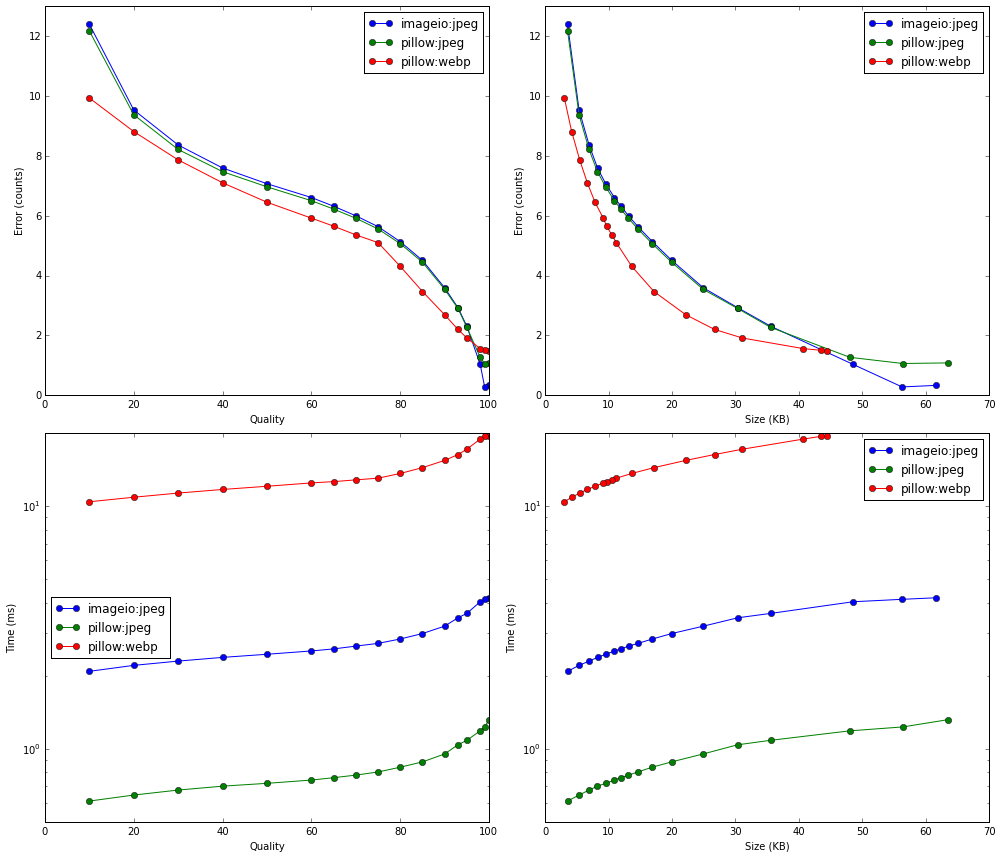

In [93]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))

package = 'imageio'
fmt = 'jpeg'
plot_results(results, qualities, fmt, package, axs)

package = 'pillow'
fmt = 'jpeg'
plot_results(results, qualities, fmt, package, axs)

package = 'pillow'
fmt = 'webp'
plot_results(results, qualities, fmt, package, axs)


format_axes(axs)

plt.tight_layout()